In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import os
import pandas as pd

# ---------------------- Define Directories and File Paths ----------------------
data_dir = '02data'
user_profiles_csv = os.path.join(data_dir, 'user_profiles_llm.csv')
filtered_reviews_csv = os.path.join(data_dir, 'filtered_user_reviews.csv')

# ---------------------- Load CSV Data ----------------------
# Load the user profiles DataFrame.
user_profiles = pd.read_csv(user_profiles_csv)
print(f"Loaded {len(user_profiles)} user profiles from {user_profiles_csv}")

# Load the filtered reviews DataFrame.
df_reviews = pd.read_csv(filtered_reviews_csv)
print(f"Loaded {len(df_reviews)} filtered reviews from {filtered_reviews_csv}")

# ---------------------- Filter the Reviews DataFrame ----------------------
# Keep only reviews where:
#   - has_car equals "Yes"
#   - car_model is not missing
#   - fuel_type is not "Unknown"
df_reviews = df_reviews.loc[
    (df_reviews.has_car == "Yes") &
    (df_reviews.car_model.notna()) &
    (df_reviews.fuel_type != "Unknown")
].reset_index(drop=True)
print(f"After filtering, {len(df_reviews)} reviews remain.")

# ---------------------- Merge Fuel Type Information into User Profiles ----------------------
# Merge user_profiles with df_reviews on author/user_id via a left join.
# Assume user_profiles.author corresponds to df_reviews.user_id.
dataset = user_profiles.merge(df_reviews, left_on="author", right_on="user_id", how="left")
dataset = dataset.drop(columns=["user_id"]).reset_index(drop=True)

# ---------------------- Select the Feature and Target Columns ----------------------
# We assume that the final dataset should only include the six feature columns and the target column fuel_type.
features = ['interest', 'attitude', 'technical_expertise', 'adoption_readiness', 'engagement', 'communication_clarity']
dataset = dataset[features + ['fuel_type']]

# ---------------------- Filter Out Rows with All Zero Feature Values ----------------------
# Remove rows where all the six feature columns sum up to zero.
dataset = dataset[~(dataset[features].sum(axis=1) == 0)]
dataset = dataset.reset_index(drop=True)
print("After filtering out rows with all zero feature values, dataset shape:", dataset.shape)

# ---------------------- Save the Final Dataset ----------------------
output_file = os.path.join(data_dir, 'dataset.csv')
dataset.to_csv(output_file, index=False)
print(f"Final dataset saved to {output_file}")

Loaded 672 user profiles from 02data/user_profiles_llm.csv
Loaded 4242 filtered reviews from 02data/filtered_user_reviews.csv
After filtering, 2030 reviews remain.
After filtering out rows with all zero feature values, dataset shape: (669, 7)
Final dataset saved to 02data/dataset.csv


Loaded dataset with shape: (669, 7)
Training set shape: (468, 6), Testing set shape: (201, 6)
Model Evaluation Results:
                       Model  Accuracy  Macro Precision  Macro Recall  \
0        Logistic Regression  0.626866         0.581098      0.540105   
1              Random Forest  0.597015         0.565217      0.562526   
2  Support Vector Classifier  0.626866         0.812500      0.506579   
3        K-Nearest Neighbors  0.611940         0.576468      0.569368   

   Macro F1  
0  0.510504  
1  0.563102  
2  0.397602  
3  0.569664  


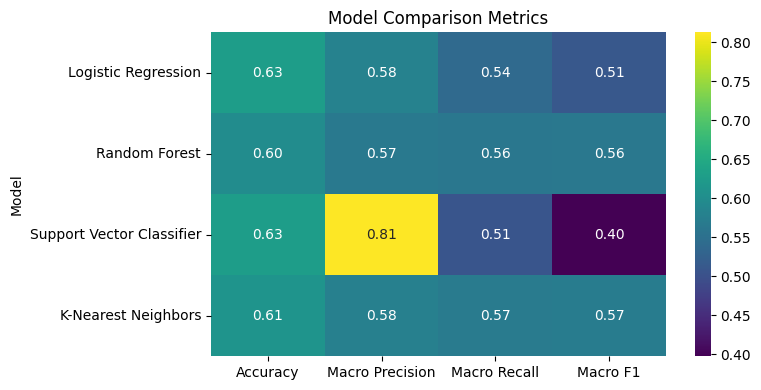

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ---------------------- Define Directories and File Paths ----------------------
data_dir = "02data"
final_dataset_csv = os.path.join(data_dir, "dataset.csv")

# ---------------------- Load and Prepare Dataset ----------------------
# Load the dataset (assumed to have 6 feature columns and the target 'fuel_type')
df = pd.read_csv(final_dataset_csv)
print(f"Loaded dataset with shape: {df.shape}")

# Map fuel_type to binary labels ("Electric": 1, "Conventional": 0)
df['fuel_type'] = df['fuel_type'].map({"Electric": 1, "Conventional": 0})

# Define the feature columns and target column
feature_columns = [
    "interest", 
    "attitude", 
    "technical_expertise", 
    "adoption_readiness", 
    "engagement", 
    "communication_clarity"
]
X = df[feature_columns]
y = df['fuel_type']

# Split the dataset into training and testing sets (70% train, 30% test) with a fixed random state.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# ---------------------- Define and Train Multiple Models ----------------------
# Define a dictionary with the classifiers to evaluate.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Evaluate each model on the test set.
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Macro Precision": precision,
        "Macro Recall": recall,
        "Macro F1": f1
    })

# Convert the results list to a DataFrame.
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

# ---------------------- Visualize the Comparison Table ----------------------
# Visualize the evaluation metrics as a heatmap for better comparison.
plt.figure(figsize=(8, 4))
# Set the 'Model' column as the index
heatmap_data = results_df.set_index("Model")
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")
plt.title("Model Comparison Metrics")
plt.tight_layout()
plt.show()